In [1]:
# use the code release version for tracking and code modifications. use the
# CHANGELOG.md file to keep track of version features, and/or release notes.
# the version file is avaiable at project root directory, check the
# global configuration setting for root directory information.
# the file is already read and is available as `__version__`
__version__ = open("../VERSION", "rt").read() # bump codecov
print(f"Current Code Version: {__version__}") # TODO : author, contact

Current Code Version: v0.1


### Code Imports

In [1]:
!pip install -r ../requirements.txt

import os     # miscellaneous os interfaces
import sys    # configuring python runtime environment
import datetime as dt
import time   # library for time manipulation, and logging
from pathlib import Path
import pickle # load/save model as a pickle file

import pandas as pd  # data manipulation and analysis
import numpy as np   # numerical operations
import torch         # pytorch library for tensor operations


In [243]:
# from copy import deepcopy      # dataframe is mutable
# from tqdm import tqdm as TQ    # progress bar for loops
# from uuid import uuid4 as UUID # unique identifier for objs

### Data Analysis Setup

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

%precision 5
%matplotlib inline
sns.set_style('whitegrid');
# plt.style.use('default-style'); # http://tinyurl.com/mpl-default-style

pd.set_option('display.max_rows', 50) # max. rows to show
pd.set_option('display.max_columns', 17) # max. cols to show
np.set_printoptions(precision = 3, threshold = 15) # set np options
pd.options.display.float_format = '{:,.5f}'.format # float precisions

def to_seconds(time_obj):
    """
    Convert a time of day object into a number representing the number of seconds since the start of the day.
    
    Args:
        time_obj (datetime.time): Time of day object.
    
    Returns:
        float: Number of seconds since the start of the day.
    """
    return (time_obj.hour * 3600 + time_obj.minute * 60 + time_obj.second)

torch.manual_seed(42)

In [245]:
# import pmdarima as pm # let `auto_arima()` find the coefficients
# import statsmodels.api as sm # statsmodels for statistical generates

In [246]:
# from stationarity import checkStationarity # https://gist.github.com/ZenithClown/f99d7e1e3f4b4304dd7d43603cef344d

In [247]:
# append `src` and sub-modules to call additional files these directory are
# project specific and not to be added under environment or $PATH variable
# sys.path.append(os.path.join("..", "src", "agents")) # agents for reinforcement modelling
# sys.path.append(os.path.join("..", "src", "engine")) # derivative engines for model control
# sys.path.append(os.path.join("..", "src", "models")) # actual models for decision making tools

## Global Argument(s)

The global arguments are *notebook* specific, however they may also be extended to external libraries and functions on import. The *boilerplate* provides a basic ML directory structure which contains a directory for `data` and a separate directory for `output`. In addition, a separate directory (`data/processed`) is created to save processed dataset such that preprocessing can be avoided.

In [3]:
ROOT = ".." # the document root is one level up, that contains all code structure
DATA = Path(ROOT) / "data" # the directory contains all data files
RAW_DATA = DATA / "raw"

# processed data directory can be used, such that preprocessing steps is not
# required to run again-and-again each time on kernel restart
PROCESSED_DATA = DATA / "processed"

# OUTPUT_DIR = os.path.join(ROOT, "output")
# IMAGES_DIR = os.path.join(OUTPUT_DIR, "images")
# MODELS_DIR = os.path.join(OUTPUT_DIR, "savedmodels")

## Historic Price Data

The historic data, i.e., any data in time series format, can be read using `pd.read_*().set_index("date")` or use a custom function to read and process from the file.

In [4]:
df = pd.read_csv(PROCESSED_DATA / "time_series_data.csv", parse_dates=True)

# Convert the "timestamp" column to datetime type
df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True).dt.tz_convert("Australia/Sydney")
df["time_of_day"] = df["timestamp"].dt.time.apply(to_seconds)
df["day_of_week"] = df["timestamp"].dt.day_of_week
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df['total_home_usage'] = df['total_home_usage'].interpolate(method='linear')
df['total_battery_charge'] = df['total_battery_charge'].interpolate(method='linear')
df['total_battery_discharge'] = df['total_battery_discharge'].interpolate(method='linear')
df['total_grid_energy_exported'] = df['total_grid_energy_exported'].interpolate(method='linear')
df['total_battery_charge'] = df['total_battery_charge'].interpolate(method='linear')
df['total_solar_generation'] = df['total_solar_generation'].interpolate(method='linear')
df.drop(columns=['total_battery_charge', 'total_battery_charge', 'total_grid_energy_exported'], inplace=True)
assert (df.isnull().sum() == 0).all(), "Validate no missing values"

data_to_resample = df[["timestamp", "total_home_usage"]]
data_half_hourly = data_to_resample.resample("30min", on="timestamp").sum().reset_index()
data_half_hourly["timestamp"] = pd.to_datetime(data_half_hourly["timestamp"], utc=True).dt.tz_convert("Australia/Sydney")
data_half_hourly["time_of_day"] = data_half_hourly["timestamp"].dt.time.apply(to_seconds)
data_half_hourly["day_of_week"] = data_half_hourly["timestamp"].dt.day_of_week
data_half_hourly["year"] = data_half_hourly["timestamp"].dt.year
data_half_hourly["month"] = data_half_hourly["timestamp"].dt.month
data_half_hourly["day"] = data_half_hourly["timestamp"].dt.day

data = data_half_hourly
data.head()

# # data_half_hourly = data_half_hourly.reindex(columns=FEATURE_COLUMNS)
# data_half_hourly = data_half_hourly[data_half_hourly["year"] == 2024]
# data_half_hourly.head()
# data = data_half_hourly

,timestamp,total_home_usage,time_of_day,day_of_week,year,month,day
0,2021-04-22 16:30:00+10:00,462.81380,59400,3,2021,4,22
1,2021-04-22 17:00:00+10:00,509.39298,61200,3,2021,4,22
2,2021-04-22 17:30:00+10:00,"2,488.15483",63000,3,2021,4,22
3,2021-04-22 18:00:00+10:00,"1,090.88780",64800,3,2021,4,22
4,2021-04-22 18:30:00+10:00,"2,677.67457",66600,3,2021,4,22


## Learner

In [91]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.optim import Adam
from collections import defaultdict
from typing import List, Callable
import matplotlib.pyplot as plt


class Callback:
    def __init__(self):
        pass

    def before_fit(self, learner):
        pass

    def before_epoch(self, learner):
        pass

    def before_batch(self, learner):
        pass

    def after_batch(self, learner):
        pass

    def after_epoch(self, learner):
        pass

    def after_fit(self, learner):
        pass


class Metric:
    def __init__(self, name: str):
        self.name = name
        self.values = []

    def reset(self):
        self.values = []

    def accumulate(self, preds, targets):
        raise NotImplementedError(
            "accumulate should be implemented in the derived class"
        )

    def compute(self):
        raise NotImplementedError("compute should be implemented in the derived class")


class Accuracy(Metric):
    def __init__(self):
        super().__init__(name="accuracy")

    def accumulate(self, preds, targets):
        _, preds = torch.max(preds, dim=1)
        # print(f"preds: {preds} targets:{targets}")
        # self.values.append((preds == targets).float().mean().item())

    def compute(self):
        # print(f"Accuracy: {self.values} {self.values}")
        return 0  # sum(self.values) / len(self.values)


class Learner:
    def __init__(
        self,
        model: nn.Module,
        dls: List[DataLoader],
        loss_fn: Callable,
        opt_func: Callable = Adam,
        metrics: List[Metric] = None,
        callbacks: List[Callback] = None,
    ):
        self.model = model
        self.dls = dls  # [train_dl, valid_dl]
        self.loss_fn = loss_fn
        self.opt = opt_func(model.parameters())
        self.metrics = metrics or []
        self.cbs = callbacks or []
        self.epoch = 0
        self.train_losses = []  # To track training losses
        self.valid_losses = []  # To track validation losses

    def one_batch(self, batch):
        xb, yb = batch
        preds = self.model(xb)
        # print(f"preds: {preds.shape} xb: {xb.shape} yb: {yb.shape}")
        loss = self.loss_fn(preds[:,0], yb)
        return preds, loss

    def fit(self, n_epochs: int):
        for cb in self.cbs:
            cb.before_fit(self)

        for epoch in range(n_epochs):
            self.epoch = epoch
            train_loss = self.train()
            valid_loss = self.validate()
            self.train_losses.append(train_loss)
            self.valid_losses.append(valid_loss)

            metrics_dict = {metric.name: metric.compute() for metric in self.metrics}
            print(
                f"Epoch {self.epoch} - Training loss: {train_loss:.4f}, Validation loss: {valid_loss:.4f}, {metrics_dict}"
            )

        for cb in self.cbs:
            cb.after_fit(self)

    def train(self):
        self.model.train()
        total_loss = 0
        num_batches = 0

        for cb in self.cbs:
            cb.before_epoch(self)

        for i, (xb, yb) in enumerate(self.dls[0]):  # Training data loader
            for cb in self.cbs:
                cb.before_batch(self)

            # Forward pass
            preds, loss = self.one_batch((xb, yb))

            if torch.isnan(loss):
                print("Warning: Training NaN loss encountered.")
                print(f"i:{i} xb:{xb} yb:{yb}")
                return

            # Backward pass
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

            total_loss += loss.item()
            num_batches += 1

            for cb in self.cbs:
                cb.after_batch(self)

        for cb in self.cbs:
            cb.after_epoch(self)

        if num_batches == 0:
            print("Warning: No batches in the training data loader")

        # Return average loss for this epoch
        return total_loss / num_batches

    def validate(self):
        self.model.eval()
        total_loss = 0
        num_batches = 0
        with torch.no_grad():
            for xb, yb in self.dls[1]:  # Validation data loader
                preds, loss = self.one_batch((xb, yb))

                if torch.isnan(loss):
                    print("Warning: Validation NaN loss encountered")

                total_loss += loss.item()
                num_batches += 1
                for metric in self.metrics:
                    metric.accumulate(preds, yb)

        if num_batches == 0:
            print("Warning: No batches in the validation data loader")

        # Return average validation loss for this epoch
        avg_loss = total_loss / num_batches
        return avg_loss

    def predict(self, xb: torch.Tensor, activation: Callable = None):
        """Generate predictions for input data."""
        self.model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            preds = self.model(xb)  # Get raw model outputs (logits for classification)
        
        # Post-process if needed (e.g., apply softmax or argmax for classification)
        if activation is not None:
            preds = activation(preds)

        return preds

    def plot_losses(self):
        plt.plot(self.train_losses, label="Training Loss")
        plt.plot(self.valid_losses, label="Validation Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training and Validation Losses")
        plt.legend()
        plt.show()

## The Model

In [92]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler


from torch.optim import Adam
import torch.utils
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import torch.utils.data


class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=0.2)
        self.fc = nn.Linear(hidden_size, output_size)
        # self.activation = nn.Tanh()

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out


# Load and preprocess data
def load_data(input_data: pd.DataFrame, columns: List[str], column_transformer: ColumnTransformer = None):
    # Assuming the DataFrame has FEATURE_COLUMNS
    normalized_data = input_data[columns]

    if column_transformer:
        # When using a column transformer, the column order is not preserved. To preseve the column order,
        # we set the out to be a dataframe so we can "fix" the order before returning it as an array.
        # See https://stackoverflow.com/a/77702955
        normalized_data = column_transformer.fit_transform(normalized_data)
        normalized_data = normalized_data.rename(columns=lambda x: x.split('__', 1)[-1])
        normalized_data = normalized_data[columns]
    return normalized_data.values


# Create sequences for LSTM
def create_sequences(dataset, sequence_length):
    features = []
    targets = []
    for i in range(len(dataset) - sequence_length):
        features.append(dataset[i : i + sequence_length])
        targets.append(dataset[i + sequence_length][-1])
    return torch.tensor(features, dtype=torch.float32), torch.tensor(
        targets, dtype=torch.float32
    )  # features, targets


# Training function
# def train_model(model, train_loader, num_epochs, criterion, optimizer):
#     model.train()
#     for epoch in range(num_epochs):
#         for sequences, labels in train_loader:
#             # sequences = sequences.to(device)
#             # labels = labels.to(device)

#             # Forward pass
#             outputs = model(sequences)
#             loss = criterion(outputs, labels)

#             # Backward pass and optimization
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()

#         if (epoch + 1) % 10 == 0:
#             print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}')


# Create a custom Dataset for fastai
# class TimeSeriesDataset(Dataset):
#     def __init__(self, sequences, labels):
#         self.sequences = sequences
#         self.labels = labels

#     def __len__(self):
#         return len(self.sequences)

#     def __getitem__(self, idx):
#         return self.sequences[idx], self.labels[idx]

## Training

In [94]:
from functools import partial
from sklearn.metrics import mean_squared_error
from torch.utils.data import DataLoader

FEATURE_COLUMNS = [
    # "year",
    "month",
    # "day",
    "day_of_week",
    "time_of_day",
    # "temperature",
    # "humidity",
    # "wind_speed",
    # "precipitation",
    # "cloud_cover",
    # "weather_description",
    "total_home_usage",
    # "grid_energy_export",
]
TARGET_COLUMN = ["total_home_usage"]
use_last_num_data_points = 24 * 2 * 30 * 15  # 12 months of data

# Hyperparameters

input_size = len(FEATURE_COLUMNS)
hidden_size = 128  # LSTM hidden layer size
num_layers = 2  # Number of LSTM layers
output_size = 1  # Predicting one value (Energy consumption)
sequence_length = 24 * 2  # Sequence length - 24 hours data
batch_size = 300  # Batch size for training
num_epochs = 10  # Number of training epochs
learning_rate = 0.001

# device = torch.device(
#     "cuda"
#     if torch.cuda.is_available()
#     else "mps" if torch.backends.mps.is_available() else "cpu"
# )
device = "mps"

# Load and preprocess data
column_transformer = ColumnTransformer(
    transformers=[
        ("standard", StandardScaler(), ["total_home_usage"]),
        (
            "minmax",
            MinMaxScaler(feature_range=(0, 1)),
            [col for col in FEATURE_COLUMNS if col != "total_home_usage"],
        ),
    ]
)
column_transformer.set_output(transform="pandas")

input_data = load_data(data[-use_last_num_data_points:], FEATURE_COLUMNS, column_transformer)
target_scaler = column_transformer.named_transformers_["standard"]

# Create sequences for training
features, targets = create_sequences(input_data, sequence_length)
features = features.to(device)
targets = targets.to(device)
print(f"features.shape: {features.shape} targets.shape: {targets.shape}")

train_size = int(0.9 * len(features))
valid_size = len(features) - train_size

# Create DataLoaders
train_ds = torch.utils.data.TensorDataset(features[:train_size], targets[:train_size])
valid_ds = torch.utils.data.TensorDataset(features[train_size:], targets[train_size:])

trainloader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
validloader = DataLoader(valid_ds, batch_size=batch_size, shuffle=False)

# Define model, loss function, and optimizer
model = LSTM(input_size, hidden_size, num_layers, output_size)
model = model.to(device)

# Instantiate Learner
loss_fn = nn.MSELoss()
learner = Learner(model, [trainloader, validloader], loss_fn, metrics=[Accuracy()])

features.shape: torch.Size([21552, 48, 4]) targets.shape: torch.Size([21552])


Epoch 0 - Training loss: 0.4461, Validation loss: 0.7910, {'accuracy': 0}
Epoch 1 - Training loss: 0.3354, Validation loss: 0.8369, {'accuracy': 0}
Epoch 2 - Training loss: 0.3237, Validation loss: 0.8232, {'accuracy': 0}
Epoch 3 - Training loss: 0.3062, Validation loss: 0.7524, {'accuracy': 0}
Epoch 4 - Training loss: 0.2976, Validation loss: 0.7223, {'accuracy': 0}
Epoch 5 - Training loss: 0.2979, Validation loss: 0.8051, {'accuracy': 0}
Epoch 6 - Training loss: 0.2847, Validation loss: 0.7323, {'accuracy': 0}
Epoch 7 - Training loss: 0.2770, Validation loss: 0.7721, {'accuracy': 0}
Epoch 8 - Training loss: 0.2688, Validation loss: 0.7500, {'accuracy': 0}
Epoch 9 - Training loss: 0.2742, Validation loss: 0.7188, {'accuracy': 0}
Epoch 10 - Training loss: 0.2571, Validation loss: 0.7526, {'accuracy': 0}
Epoch 11 - Training loss: 0.2613, Validation loss: 0.7393, {'accuracy': 0}
Epoch 12 - Training loss: 0.2552, Validation loss: 0.7458, {'accuracy': 0}
Epoch 13 - Training loss: 0.2477, V

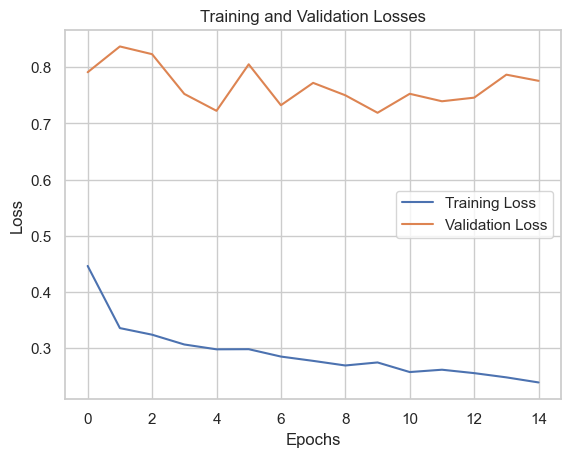

In [95]:

# Train the model using fastai's training loop
#learn.fit(num_epochs)

# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# train_model(model, trainloader, 10, loss_fn, optimizer)

# Train the model
learner.fit(15)

# Plot training and validation losses
learner.plot_losses()

# Epoch 0 - Training loss: 0.0065, Validation loss: 0.0029, {'accuracy': 0.0061215671211830225}

## Prediction

In [96]:
import torch
from datetime import timedelta


predict_from = datetime(2024, 9, 27, 0, 0, 0)


def predict_next_step(sequence_df: pd.DataFrame):
    input_sequence = column_transformer.transform(sequence_df[FEATURE_COLUMNS])
    input_sequence = input_sequence.rename(columns=lambda x: x.split('__', 1)[-1])

    input_sequence_tensor = torch.tensor(input_sequence[FEATURE_COLUMNS].values, dtype=torch.float32, device=device).unsqueeze(0)
    prediction_from_model = learner.predict(input_sequence_tensor)
    transformed_prediction = target_scaler.inverse_transform(prediction_from_model.cpu())
    prediction = transformed_prediction[0, -1]
    return prediction

def predict_next_steps(sequence_df: pd.DataFrame, steps: int, on_new_row: Callable[[pd.DataFrame], None] = None):
    predictions = []
    for i in range(steps):
        prediction = predict_next_step(sequence_df)

        next_time = sequence_df[-1:]["timestamp"].to_numpy()[0].to_pydatetime() + timedelta(minutes=30)
        new_row = pd.DataFrame(
            {
                "timestamp": [next_time],
                "time_of_day": [to_seconds(next_time)],
                "year": [next_time.year],
                "month": [next_time.month],
                "day": [next_time.day],
                "day_of_week": [next_time.weekday()],
                "total_home_usage": [prediction],
            }
        )
        if on_new_row:
            on_new_row(new_row)
        sequence_df = pd.concat([sequence_df, new_row])[(-sequence_length):]
    return sequence_df


new_data = data[(-1):]
def append_to_data(new_row: pd.DataFrame):
    global new_data
    new_data = pd.concat([new_data, new_row])

predict_next_steps(data[(-sequence_length):], 2 * 24 * 30, on_new_row=append_to_data)


# his_data = data[(data["year"] == 2024) & (data["month"] == 9)]
# new_data = predict(predict_from, his_data, 30 * 24, device=device)

,timestamp,total_home_usage,time_of_day,day_of_week,year,month,day
0,2024-10-30 01:00:00+11:00,688.84338,3600,2,2024,10,30
0,2024-10-30 01:30:00+11:00,691.09925,5400,2,2024,10,30
0,2024-10-30 02:00:00+11:00,681.78723,7200,2,2024,10,30
0,2024-10-30 02:30:00+11:00,666.12107,9000,2,2024,10,30
0,2024-10-30 03:00:00+11:00,649.19117,10800,2,2024,10,30
0,2024-10-30 03:30:00+11:00,635.11539,12600,2,2024,10,30
0,2024-10-30 04:00:00+11:00,621.02429,14400,2,2024,10,30
0,2024-10-30 04:30:00+11:00,597.81346,16200,2,2024,10,30
0,2024-10-30 05:00:00+11:00,564.12889,18000,2,2024,10,30
0,2024-10-30 05:30:00+11:00,532.98468,19800,2,2024,10,30


In [98]:
# temp_data = df[(df['year'] == 2024) & (df['month'] == 9) & (df['day'] == 23)]
# t = temp_data["consumer_energy_imported_from_grid"] + temp_data["consumer_energy_imported_from_solar"] + temp_data["consumer_energy_imported_from_battery"] + temp_data["consumer_energy_imported_from_generator"]
# g = temp_data["grid_services_energy_imported"] + temp_data["grid_services_energy_exported"]
# # consumer_energy_imported_from_grid", "consumer_energy_imported_from_solar", "consumer_energy_imported_from_battery",        "consumer_energy_imported_from_generator"

# plt.figure()
# plt.plot(temp_data["total_home_usage_filled"])

# temp_data["time_of_day"]
new_data.head()

,timestamp,total_home_usage,time_of_day,day_of_week,year,month,day
60350,2024-09-30 23:30:00+10:00,246.00000,84600,0,2024,9,30
0,2024-10-01 00:00:00+10:00,530.36954,0,1,2024,10,1
0,2024-10-01 00:30:00+10:00,652.98651,1800,1,2024,10,1
0,2024-10-01 01:00:00+10:00,670.92190,3600,1,2024,10,1
0,2024-10-01 01:30:00+10:00,675.20279,5400,1,2024,10,1


## Visualization

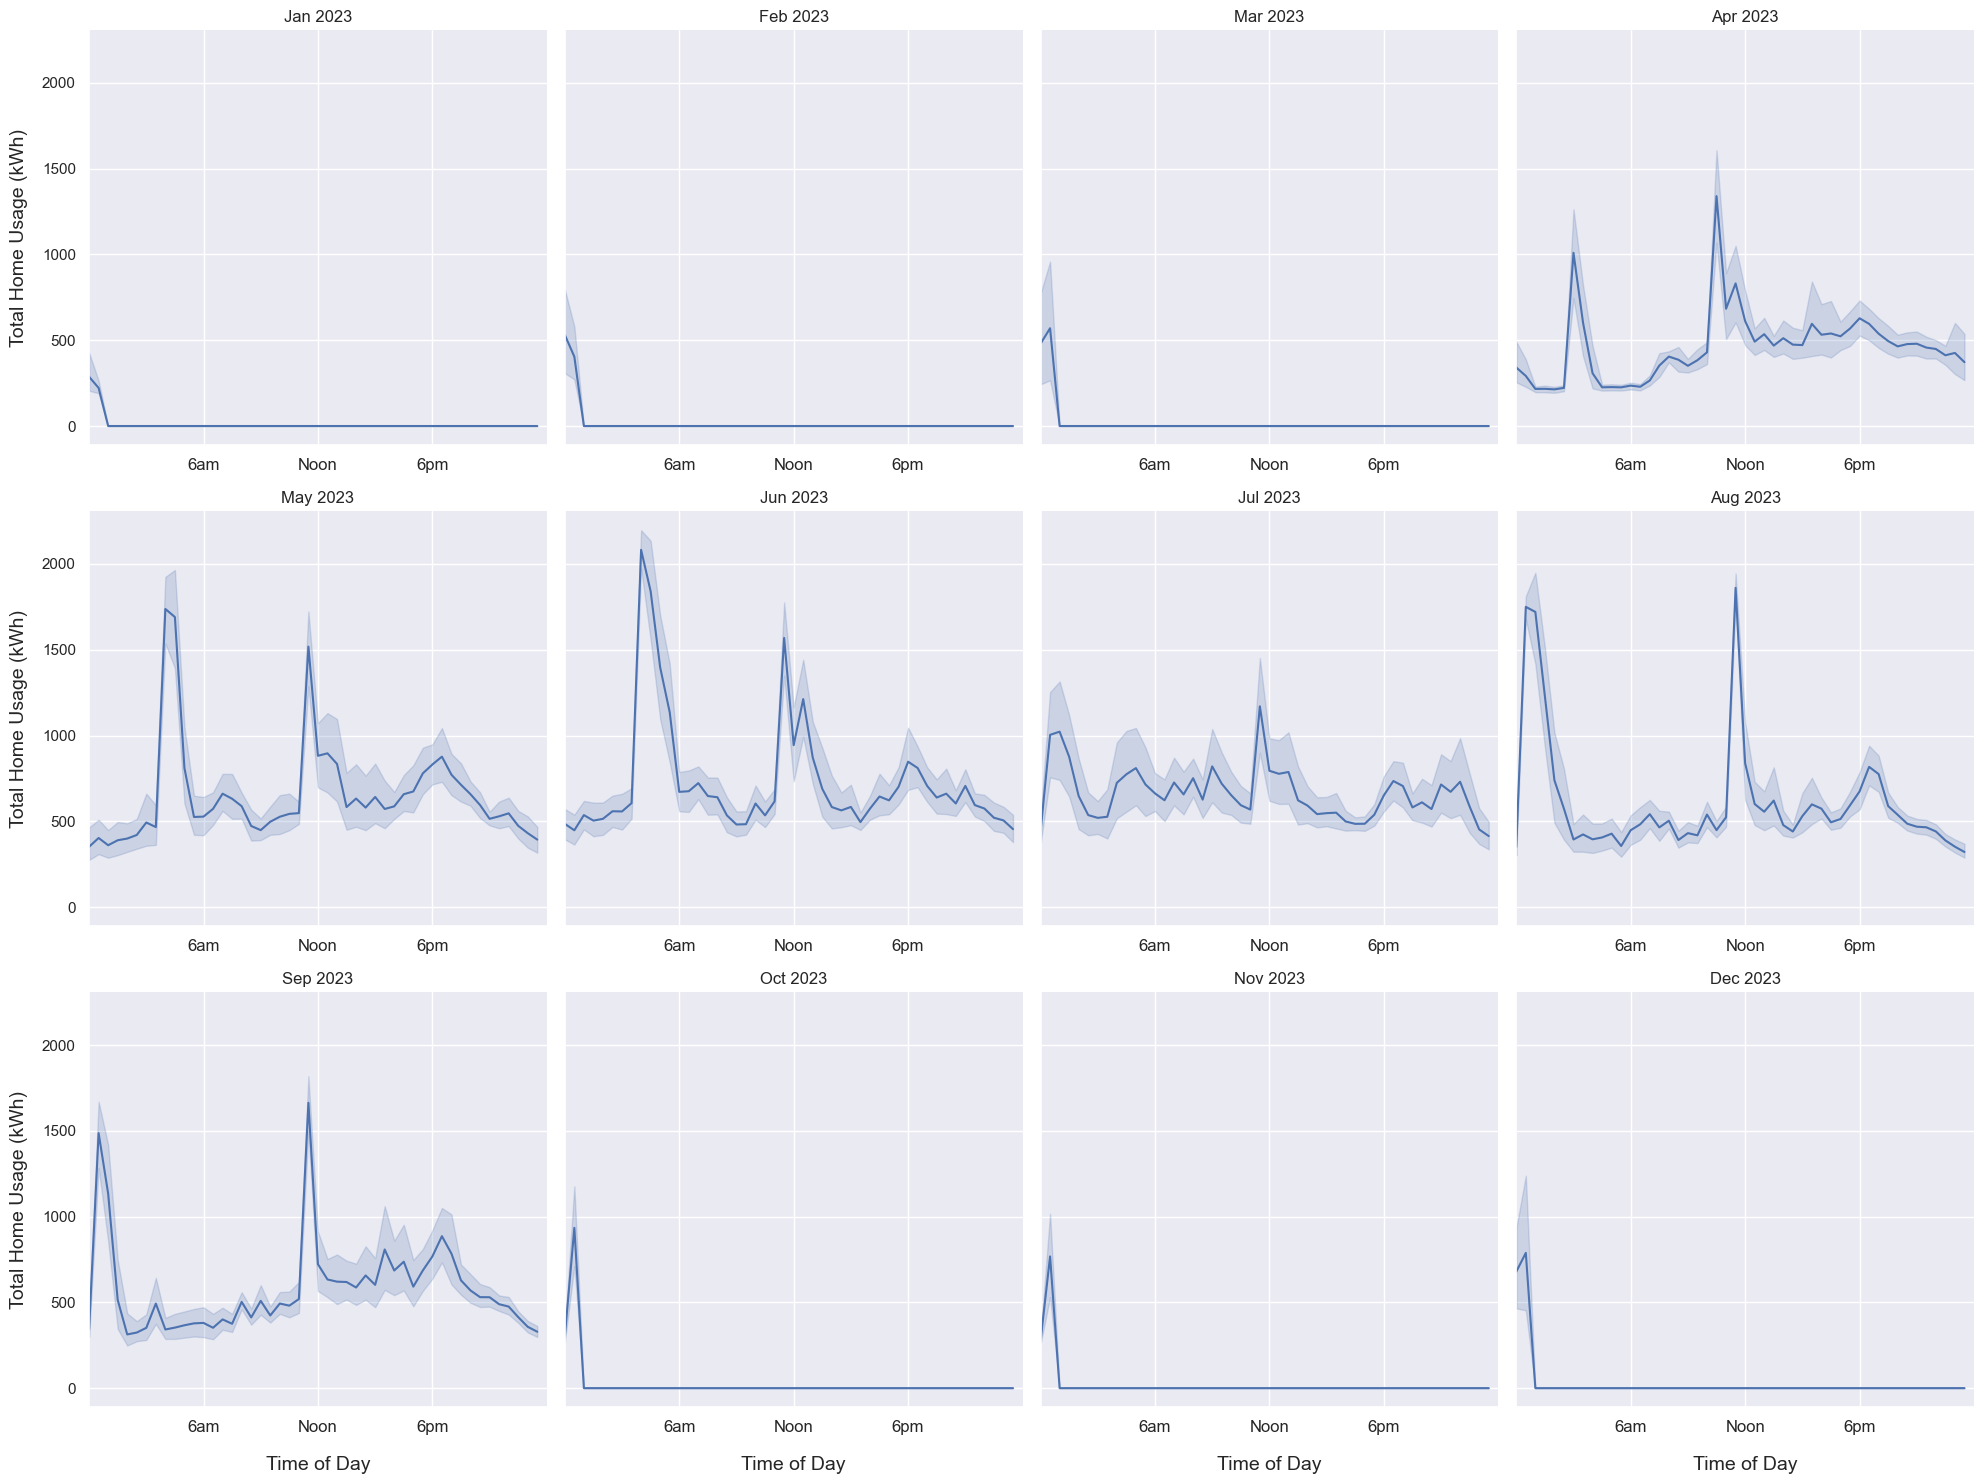

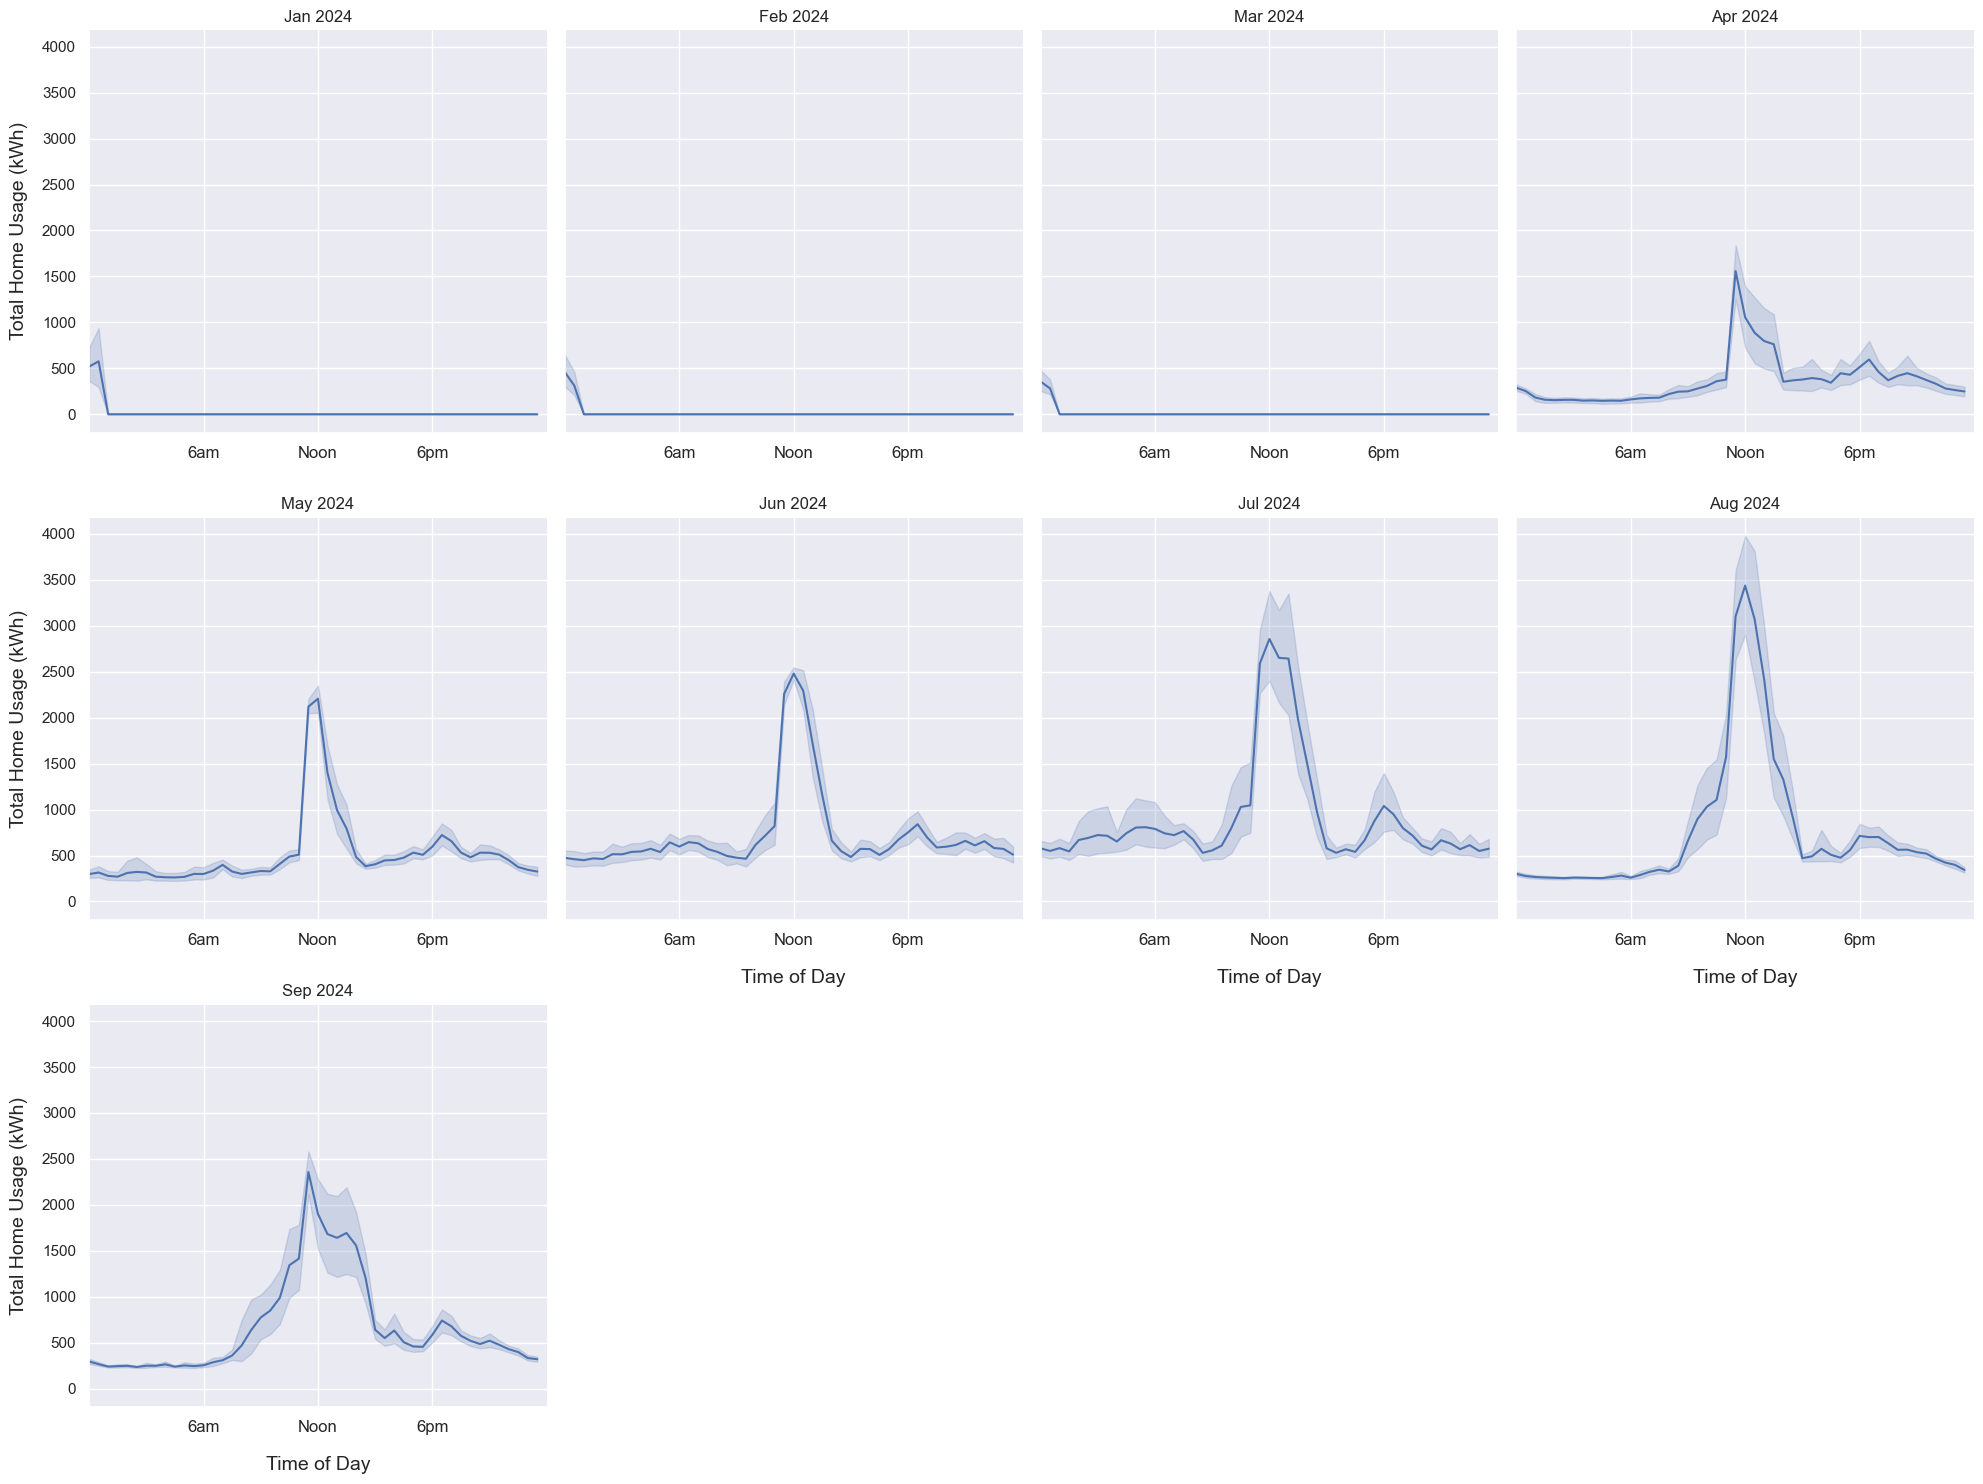

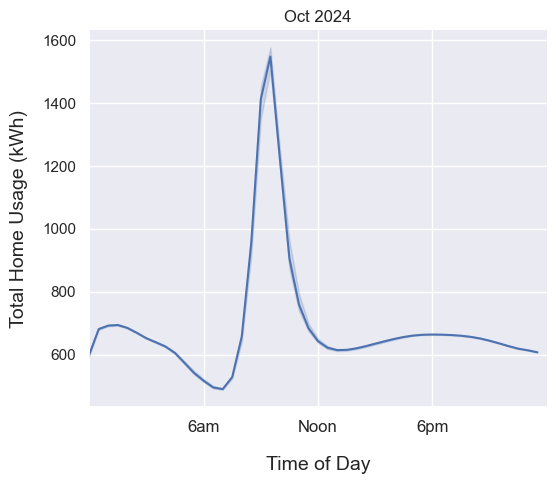

In [99]:
%matplotlib inline
from ipywidgets import interact

sns.set_theme()
#sns.set_context("notebook")

def scale_hour_to_seconds(hour: int):
    return hour * 60 * 60

year = 2023

def plot_consumption(data: pd.DataFrame, year: int):
    def month_titles_for_year(year):
        return {
            1: f"Jan {year}",
            2: f"Feb {year}",
            3: f"Mar {year}",
            4: f"Apr {year}",
            5: f"May {year}",
            6: f"Jun {year}",
            7: f"Jul {year}",
            8: f"Aug {year}",
            9: f"Sep {year}",
            10: f"Oct {year}",
            11: f"Nov {year}",
            12: f"Dec {year}"
        }
    month_titles = month_titles_for_year(year)

    g1 = sns.relplot(
        data=data[data["year"] == year],
        kind="line",
        x="time_of_day",
        y="total_home_usage",
        # hue="day_of_week",
        col="month",
        col_wrap=4,
    )

    for ax in g1.axes.flat:
        ax.tick_params(axis='x', labelbottom=True)  # Thi show x-axis labels on the bottom for all subplots
        ax.set_ylabel("Total Home Usage (kWh)", labelpad=10, fontsize=14)  # set y-axis label font size
        ax.set_xlabel("Time of Day", labelpad=15, fontsize=14)  # set x-axis label font size

        # Set x-axis tick label font size and rotation
        ax.tick_params(axis='x', labelsize=12)

        # Set x-axis limits
        ax.set_xlim([0, 86400])  # set x-axis limits to 0-24

        # Set custom x-axis tick labels
        ax.set_xticks([21600, 43200, 64800])  # set custom tick locations
        ax.set_xticklabels(['6am', 'Noon', '6pm'])  # set custom tick labels

        # Get the current month title
        month = int(ax.get_title().split("=")[1])

        # Customize the month title using the dictionary
        ax.set_title(month_titles[month])
        
    g1.tight_layout()


plot_consumption(data, 2023)
plot_consumption(data, 2024)
plot_consumption(new_data[new_data["month"] == 10], 2024)

# interact(update_g1, day=range(30))

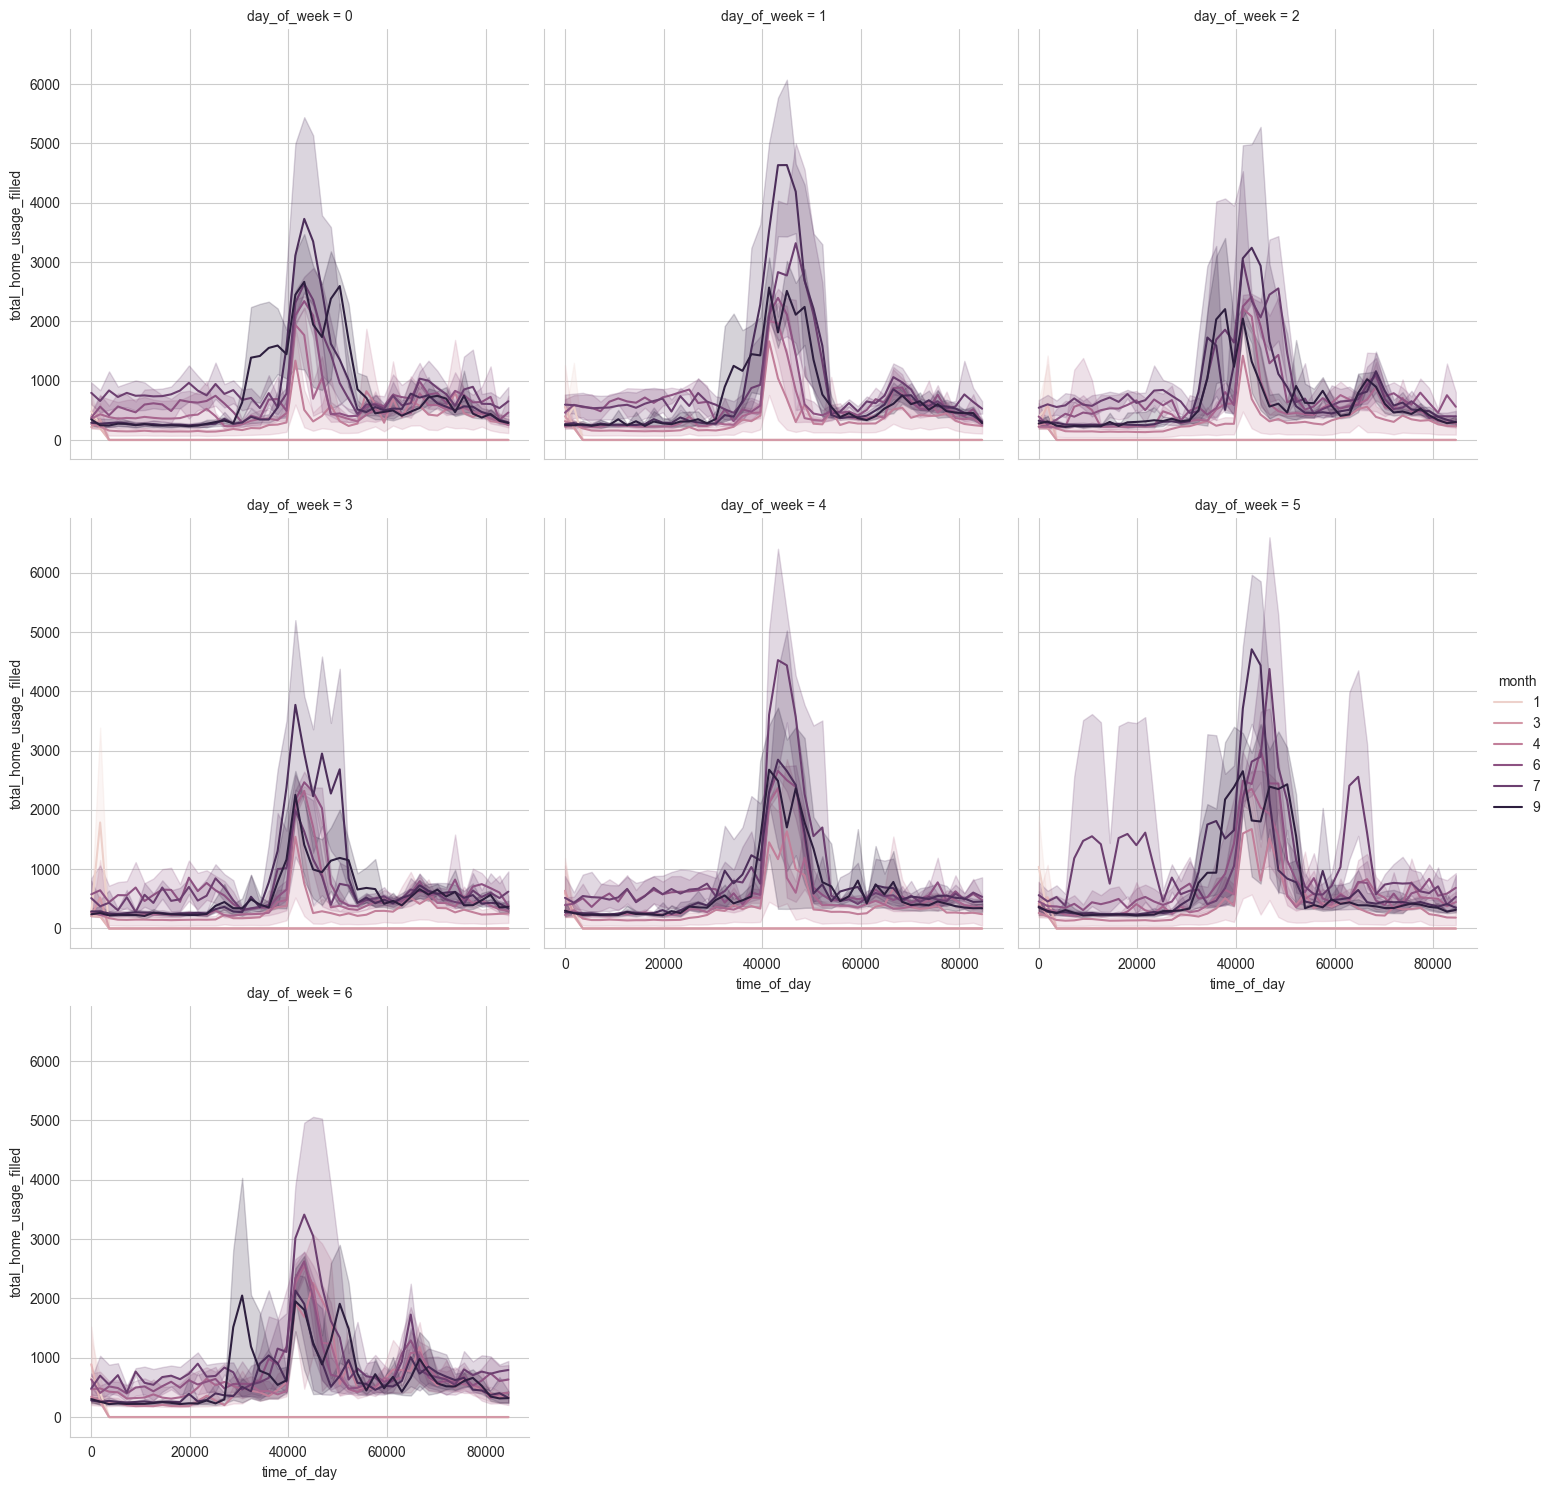

In [258]:
import seaborn as sns

d = data_half_hourly[data_half_hourly["year"] == 2024]

sns.relplot(
    data=d,
    kind="line",
    x="time_of_day",
    y="total_home_usage_filled",
    hue="month",
    col="day_of_week",
    col_wrap=3,
)

In [5]:
data[(data["year"] == 2024) & (data["month"] == 1)]

,timestamp,total_home_usage,time_of_day,day_of_week,year,month,day
47197,2024-01-01 00:00:00+11:00,445.00000,0,0,2024,1,1
47198,2024-01-01 00:30:00+11:00,181.00000,1800,0,2024,1,1
47199,2024-01-01 01:00:00+11:00,0.00000,3600,0,2024,1,1
47200,2024-01-01 01:30:00+11:00,0.00000,5400,0,2024,1,1
47201,2024-01-01 02:00:00+11:00,0.00000,7200,0,2024,1,1
...,...,...,...,...,...,...,...
48680,2024-01-31 21:30:00+11:00,0.00000,77400,2,2024,1,31
48681,2024-01-31 22:00:00+11:00,0.00000,79200,2,2024,1,31
48682,2024-01-31 22:30:00+11:00,0.00000,81000,2,2024,1,31
48683,2024-01-31 23:00:00+11:00,0.00000,82800,2,2024,1,31
